### Vanilla Machine Learning Notebook
This notebook is created to get information on naive implementation of Neural Network (agents). This will be then compared to parallelization techniques used in industry for improved learning efficiency and quick convergence. 

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# data rendering
import matplotlib.pyplot as plt
import numpy as np

import time


In [42]:
# set random seed for reproducability
torch.manual_seed(42)

In [43]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [44]:
batch_size = 128

In [45]:
# Load MNIST dataset with PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and stdev
])

# Download training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Download test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [46]:
# i = 10
# # test data
# images, labels = next(iter(train_loader))
# img = images[i]
# label = labels[i]

# # plot image
# plt.imshow(img.squeeze(), cmap="gray")
# plt.title(f"Label: {label.item()}")
# plt.axis("off")
# plt.show
    

In [47]:
# Simple Neural net implementation (no convolution)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # flatten the 28x28 images
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.ff1 = nn.Linear(28*28, 128)    # 28*28 -> 128
        self.ff2 = nn.Linear(128, 64)       # 128 -> 64
        self.ff3 = nn.Linear(64, 10)        # 64 -> 10
        
    def forward(self, x):
        # forward pass
        x = self.flatten(x)
        x = self.relu(self.ff1(x))
        x = self.relu(self.ff2(x))
        x = self.ff3(x)
        return x
    
                
        


In [48]:
model = SimpleNN().to(device)
print(model)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (ff1): Linear(in_features=784, out_features=128, bias=True)
  (ff2): Linear(in_features=128, out_features=64, bias=True)
  (ff3): Linear(in_features=64, out_features=10, bias=True)
)


In [49]:
#hyper-parameters
learning_rate = 0.001
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [50]:
# training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [51]:
# Training
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to the device (CPU or GPU)
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # fwd pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        # track stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # print stats every 100 batches
        if batch_idx % 100 == 00:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {running_loss/100:.4f}, '
                  f'Accuracy: {100 * correct/total:.2f}%')
            running_loss = 0.0
    
    # Calculate epoch statistics
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    return train_loss, train_acc
        

In [52]:
# Testing
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            # Move data to the device (CPU or GPU)
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, target)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    val_losses.append(test_loss)
    val_accs.append(test_acc)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    return test_loss, test_acc


In [53]:
# Train the model
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test()

end_time = time.time()


Epoch: 1, Batch: 1, Loss: 0.0231, Accuracy: 10.94%
Epoch: 1, Batch: 101, Loss: 2.3082, Accuracy: 9.57%
Epoch: 1, Batch: 201, Loss: 2.2723, Accuracy: 10.67%
Epoch: 1, Batch: 301, Loss: 2.2383, Accuracy: 13.47%
Epoch: 1, Batch: 401, Loss: 2.2020, Accuracy: 17.73%
Test Loss: 2.1499, Test Accuracy: 43.66%
Epoch: 2, Batch: 1, Loss: 0.0217, Accuracy: 39.06%
Epoch: 2, Batch: 101, Loss: 2.1319, Accuracy: 45.90%
Epoch: 2, Batch: 201, Loss: 2.0837, Accuracy: 48.95%
Epoch: 2, Batch: 301, Loss: 2.0329, Accuracy: 50.76%
Epoch: 2, Batch: 401, Loss: 1.9729, Accuracy: 52.00%
Test Loss: 1.8849, Test Accuracy: 57.38%
Epoch: 3, Batch: 1, Loss: 0.0190, Accuracy: 62.50%
Epoch: 3, Batch: 101, Loss: 1.8577, Accuracy: 56.81%
Epoch: 3, Batch: 201, Loss: 1.7896, Accuracy: 57.33%
Epoch: 3, Batch: 301, Loss: 1.7168, Accuracy: 58.36%
Epoch: 3, Batch: 401, Loss: 1.6285, Accuracy: 59.60%
Test Loss: 1.5167, Test Accuracy: 67.15%
Epoch: 4, Batch: 1, Loss: 0.0153, Accuracy: 70.31%
Epoch: 4, Batch: 101, Loss: 1.4834, Ac

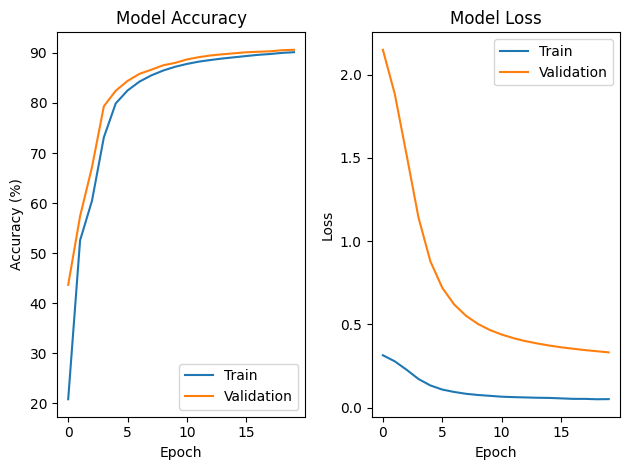

In [54]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [55]:
print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 382.6086 seconds
